# 1D GMM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import corner as corner

In [2]:
%matplotlib notebook

### Data simulation

<IPython.core.display.Javascript object>


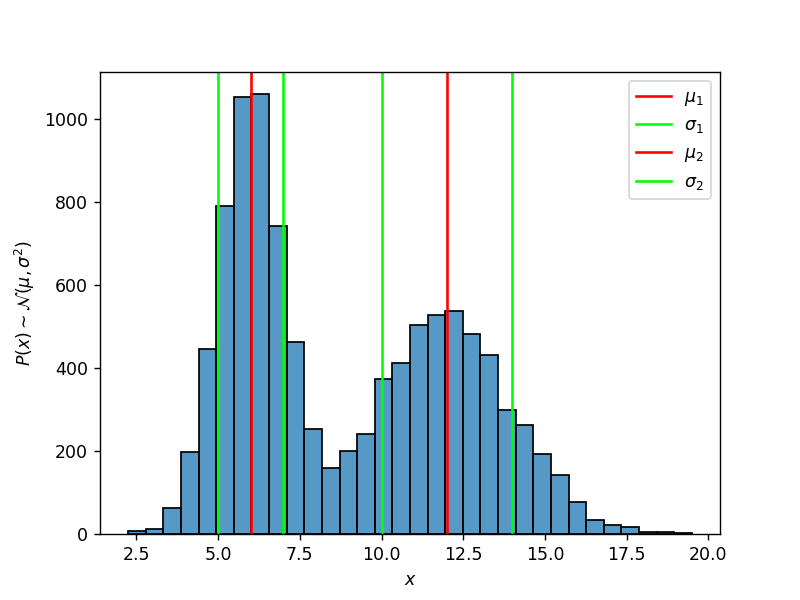

In [10]:
set_seed = False
if set_seed:
    np.random.seed(923114)

N = 10000
μ = [6, 12]
σ = [1, 2]
weight = 0.5

data1 = norm.rvs(size=N, loc=μ[0], scale=σ[0])
data2 = norm.rvs(size=N, loc=μ[1], scale=σ[1])
data = data1
sel = np.where(np.random.rand(N) > weight)
data[sel] = data2[sel]


plt.figure()
ax = sns.histplot(data)
plt.ylabel(r'$P(x)\sim\mathcal{N}(\mu, \sigma^2)$')
plt.xlabel(r'$x$')
ax.axvline(μ[0], color='r', label=r'$μ_1$')
ax.axvline(μ[0]+σ[0], color='lime', label=r'$σ_1$')
ax.axvline(μ[0]-σ[0], color='lime')
ax.axvline(μ[1], color='r', label=r'$μ_2$')
ax.axvline(μ[1]+σ[1], color='lime', label=r'$σ_2$')
ax.axvline(μ[1]-σ[1], color='lime')
ax.legend()

In [ ]:
def model(x, p):
    #Random bullshittery
    return p

def log_likelihood(p, x, prior_check=1):
    p = model(x, p)
    μ, σ = p
    log_norm = norm.logpdf(x, loc=μ, scale=σ)
    total = np.sum(log_norm)*prior_check
    return total

ntrials = 500
μ_guess = np.linspace(8, 12, ntrials)
σ_guess = np.linspace(2, 6, ntrials)

mapping = np.empty((ntrials, ntrials))
current_max = -np.inf
for i, mean in enumerate(μ_guess):
    for j, std in enumerate(σ_guess):
        logl = log_likelihood((mean, std), data)
        mapping[i, j] = logl
        if logl > current_max:
            current_max = logl
            best_mean = mean
            best_std = std

In [ ]:
plt.figure()
plt.imshow(mapping, cmap='afmhot', extent=[μ_guess[0], μ_guess[-1], σ_guess[0], σ_guess[-1]]
           , aspect='auto', vmax=-1400, vmin=-1445)
plt.colorbar(label='Log Likelihood')
plt.xlabel('μ')
plt.ylabel('σ')
plt.axvline(μ, color='olivedrab', label='True Values')
plt.axhline(σ, color='olivedrab')
plt.legend()
plt.show()

print(f'The best fit values are: μ = {best_mean} and σ = {best_std}')

In [ ]:
from dynesty import NestedSampler

ndim = 2

def unit_transform(u, centre, span):
    return 2*span*u + centre-span

def prior_transform(u):
    x = np.array(u)
    
    x[0] = unit_transform(x[0], 10, 2)
    x[1] = unit_transform(x[1], 4, 2)
    return x

sampler = NestedSampler(log_likelihood, prior_transform, ndim, logl_args=[data, 1e-6], nlive=2000)
sampler.run_nested()

z = sampler.results
results = z.samples_equal()

In [ ]:
corner.corner(results, labels=['μ', 'σ'], truths=[μ, σ]);